In [ ]:
!pip install csvwlib 

In [1]:
import requests, io, pandas as pd, numpy as np
from urllib.parse import urlencode
from pytz import timezone
from datetime import datetime, timedelta
from csvwlib import CSVWConverter
from matplotlib import pyplot as plt

labels = ['date', 'start', 'end', 'class']

data = []

def fetch(date):
    time_from = timezone('Europe/Helsinki').localize(datetime.strptime(date, '%Y-%m-%d'))
    time_to = time_from + timedelta(days=1)

    query = {
        'table': 'HYY_DMPS', 'quality': 'ANY', 'averaging': 'NONE', 'type': 'NONE',
        'from': str(time_from), 'to': str(time_to), 'variables': 'd316e1,d355e1,d398e1,'\
        'd447e1,d501e1,d562e1,d631e1,d708e1,d794e1,d891e1,d100e2,d112e2,d126e2,d141e2,d158e2,'\
        'd178e2,d200e2,d224e2,d251e2,d282e2,d316e2,d355e2,d398e2,d447e2,d501e2,d562e2,d631e2,'\
        'd708e2,d794e2,d891e2,d100e3,d112e3,d126e3,d141e3,d158e3,d178e3,d200e3'
    }
    
    url = 'https://avaa.tdata.fi/smear-services/smeardata.jsp?' + urlencode(query)
    response = requests.post(url)

    return pd.read_csv(io.StringIO(response.text))

def plot(data):
    d = data.copy(deep=True)
    d = d.iloc[:, 6:].values
    m = len(d)
    n = len(d[0])
    x = range(0, m)
    y = range(0, n)
    x, y = np.meshgrid(x, y)
    z = np.transpose(np.array([row[1:] for row in d]).astype(np.float))
    plt.figure(figsize=(10, 5), dpi=100)
    plt.pcolormesh(x, y, z)
    plt.plot((0, x.max()), (y.max()/2, y.max()/2), "r-")
    plt.colorbar()
    plt.xlim(right=m-1)
    x_ticks = np.arange(x.min(), x.max(), 6)
    x_labels = range(x_ticks.size)
    plt.xticks(x_ticks, x_labels)
    plt.xlabel('Hours')
    y_ticks = np.arange(y.min(), y.max(), 6)
    y_labels = ['3.16', '6.31', '12.6', '25.1', '50.1', '100']
    plt.yticks(y_ticks, y_labels)
    plt.ylabel('Diameter [nm]')
    plt.ylim(top=n-1)
    plt.show()

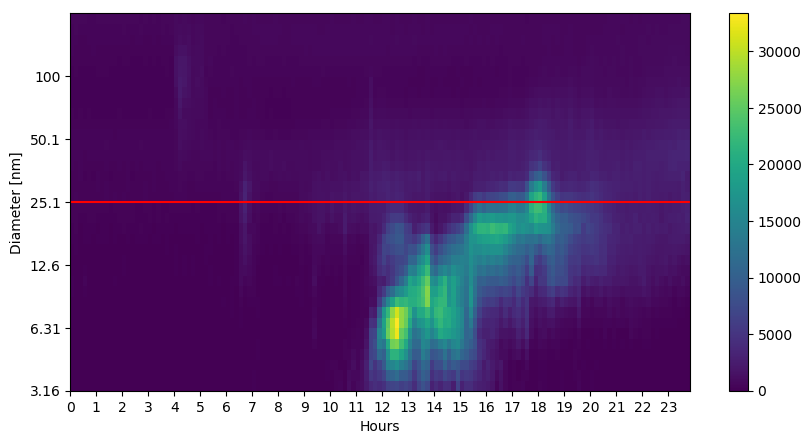

In [4]:
# Days to process
#
# Event days
# 2007-04-15, 2007-05-05, 2007-05-18, 2007-10-19, 2008-02-19, 2009-03-19, 2009-03-22 
# 2011-03-15, 2011-04-19, 2011-10-01, 2012-05-01, 2012-05-29, 2013-02-20, 2013-04-04
#
# Non Event days
# 2007-04-20, 2008-02-20, 2009-04-03, 2011-04-21, 2012-05-05, 2013-02-21

day = '2007-05-05'

plot(fetch(day))

In [6]:
start = '12:00'
end = '13:30'
classification = 'Ia'

In [7]:
data.append((day, start, end, classification))

In [8]:
df = pd.DataFrame.from_records(data, columns=labels)
df.to_csv('data.csv', index=False)

In [ ]:
g = CSVWConverter.to_rdf('https://raw.githubusercontent.com/markusstocker/carbon-workshop/master/data.csv', mode='minimal')

print(g.serialize(format='ttl').decode('utf-8'))